# MESQUAL 302: Segmented Colormap

A useful module to merge multiple linear segments into a single cohesive colormap.

## Introduction

Visualizing data with complex color scales can be challenging. Some datasets have natural break points where you want different color behavior:

- Extreme negative values in one color range
- Near-zero values with fine gradients
- Positive values in another color range
- Extreme positive values with distinct colors

Traditional linear colormaps don't handle these multi-segment needs well. The `SegmentedColorMap` and its companion `SegmentedColorMapLegend` solve this problem by allowing you to define custom segments with distinct color behaviors.

## Key Features

- Define different color gradients for different value ranges
- Seamless transitions between segments
- Support for both continuous gradients and discrete colors
- Integration with both Folium (via legend) and Plotly (via normalized colorscale)
- Configurable ticks, labels, and visual styling

## Creating a Market Price Colormap
Let's create a colormap for electricity market prices (€/MWh) with these segments:

- Extreme negative prices: -500 to -150 €/MWh (navy blue)
- Negative prices: -150 to 0 €/MWh (gradient from blue to light blue)
- Low positive prices: 0 to 150 €/MWh (gradient from light green to yellow-green)
- High positive prices: 150 to 500 €/MWh (gradient from yellow-green to orange)
- Extreme positive prices: 500 to 10000 €/MWh (red)

## Setup
First, we need to set up the environment. If you are on Colab, the first cell will clone and install all dependencies. You will have to restart the session afterwards and continue with cell 2. If you are in a local environment, make sure that you have followed the Getting started steps in the README, so that mesqual and all requirements are installed.

In [1]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import importlib.util

    def is_module_available(module_name):
        return importlib.util.find_spec(module_name) is not None

    if os.path.exists("mesqual-vanilla-studies") and is_module_available("mesqual"):
        print("✅ Environment already set up. Skipping installation.")
    else:
        print("🔧 Setting up Colab environment...")
        !git clone --recursive https://github.com/helgeesch/mesqual-vanilla-studies.git
        %cd mesqual-vanilla-studies/

        !pip install git+https://github.com/helgeesch/mesqual -U
        !pip install git+https://github.com/helgeesch/mesqual-pypsa -U
        !pip install -r requirements.txt

        print('✅ Setup complete. 🔁 Restart the session, then skip this cell and continue with the next one.')
else:
    print("🖥️ Running locally. No setup needed.")

🖥️ Running locally. No setup needed.


In [2]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import sys
    sys.path.append('/content/mesqual-vanilla-studies')
    os.chdir('/content/mesqual-vanilla-studies')
else:
    def setup_notebook_env():
        """Set working directory to repo root and ensure it's in sys.path."""
        import os
        import sys
        from pathlib import Path

        def find_repo_root(start_path: Path) -> Path:
            current = start_path.resolve()
            while current != current.parent:
                if (current / 'vanilla').exists():
                    return current
                current = current.parent
            raise FileNotFoundError(f"Repository root not found from: {start_path}")

        repo_root = find_repo_root(Path.cwd())
        os.chdir(repo_root)
        if str(repo_root) not in sys.path:
            sys.path.insert(0, str(repo_root))

    setup_notebook_env()

try:
    from mesqual import StudyManager
except ImportError:
    raise ImportError("❌ 'mesqual' not found. If you're running locally, make sure you've installed all dependencies as described in the README.")

if not os.path.isdir("studies"):
    raise RuntimeError(f"❌ 'studies' folder not found. Make sure your working directory is set to the mesqual-vanilla-studies root. Current working directory: {os.getcwd()}")

print("✅ Environment ready. Let’s go!")


✅ Environment ready. Let’s go!


In [3]:

import numpy as np
import folium
import plotly.graph_objects as go

import mesqual.visualizations.folium_viz_system as folviz
import mesqual.visualizations.value_mapping_system as valmap

from vanilla.notebook_config import configure_clean_output_for_jupyter_notebook
from vanilla.conditional_renderer import ConditionalRenderer


configure_clean_output_for_jupyter_notebook()
renderer = ConditionalRenderer()

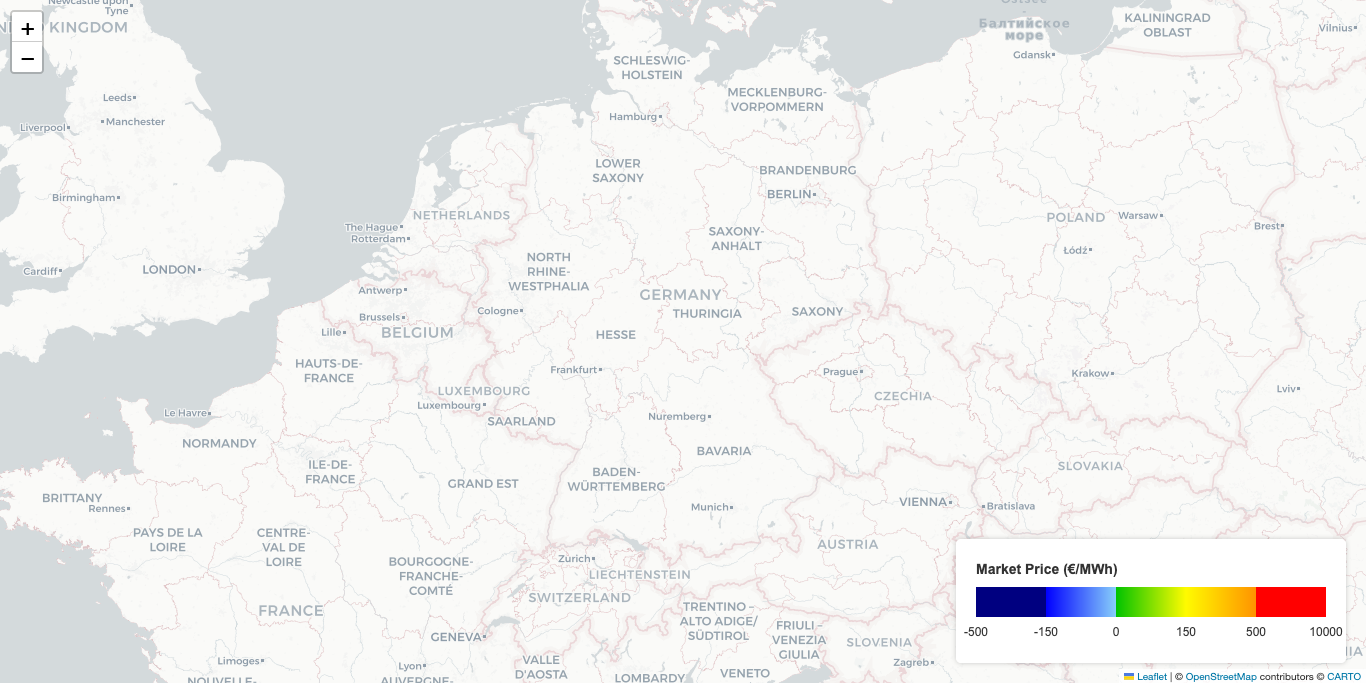

In [4]:
# Define our market price colormap segments
price_segments = {
    (-500, -150): ['#000080'],  # Navy for extreme negative prices
    (-150, 0): ['#0000FF', '#87CEFA'],  # Blue to light blue for negative prices
    (0, 150): ['#00C300', '#FFFB00'],  # Light green to yellow-green for low positive prices
    (150, 500): ['#FFFB00', '#FF9300'],  # Yellow-green to orange for high positive prices
    (500, 10000): ['#FF0000']  # Red for extreme positive prices
}

# Create a colormap without folium legend functionality 
price_colorscale = valmap.SegmentedContinuousColorscale(price_segments)

# Create a legend for Folium maps
price_legend = folviz.legends.ContinuousColorscaleLegend(
    mapping=price_colorscale,
    title="Market Price (€/MWh)",
    width=350,
    padding=20,
    background_color="#FFFFFF",
    n_ticks_per_segment=2
)

# Show the legend in a Folium map
m = folium.Map(location=[50.5, 10.5], zoom_start=6, tiles='CartoDB Positron')
price_legend.add_to(m)


renderer.show_folium(m)

This legend will be used in the next notebook (mesqual_303_geospatial_visualization.ipynb) for our geospatial visualizations of market prices.

## Using the Colormap with Plotly
The `to_normalized_colorscale()` method converts our segmented colormap to a format compatible with Plotly:

In [5]:
# Get the colorscale for Plotly
plotly_colorscale = price_colorscale.to_normalized_colorscale(num_reference_points_per_segment=5)

# Create some sample data with a range of price values
np.random.seed(42)
hours = 24
days = 7
z = np.random.normal(loc=100, scale=150, size=(days, hours))
z[2, 8:12] = -200  # Add some extreme negative values
z[5, 15:20] = 700  # Add some extreme positive values

# Create a heatmap with our custom colorscale
fig = go.Figure(data=go.Heatmap(
    z=z,
    x=[f"{h:02d}:00" for h in range(hours)],
    y=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    colorscale=plotly_colorscale,
    zmin=-500,
    zmax=10000,
))

fig.update_layout(
    title="Example: Market Prices with Segmented Colormap",
    xaxis_title="Hour of Day",
    yaxis_title="Day of Week",
)

renderer.show_plotly(fig)

RuntimeError: 

Kaleido requires Google Chrome to be installed.

Either download and install Chrome yourself following Google's instructions for your operating system,
or install it from your terminal by running:

    $ plotly_get_chrome



## Benefit of Segmented Colormaps

With our segmented colormap, we can:

1. Define a color scale split in custom segments
2. Assign distinct colors to extreme values
3. Create fine color gradients for the most common value ranges
4. Use appropriate colors for different segments (e.g., red for extreme positive prices)
5. Maintain consistent coloring across different visualizations

This approach is particularly useful for electricity market data, where extreme prices are significant but rare, and the common price range needs detailed color differentiation.


## Conclusion

The `SegmentedColorMap` module provides a powerful tool for creating color scales that match the natural segments in your data. When combined with folium and plotly, it enables consistent, informative visualizations across different platforms and chart types.

In the next notebook (mesqual_303), we'll apply this colormap to geospatial visualizations of electricity market data.